<h1 style="text-align:center;color:DodgerBlue;"> Predicting Bounding Boxes

In [1]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import cv2

<h1 style="text-align:center;color:DodgerBlue">Visualisation utilities</h1>

In [2]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color=(255, 0, 0), thickness=5):
    """
    Adds a bounding box to an image.
    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.
    
    Args:
      image: a PIL.Image object.
      ymin: ymin of bounding box.
      xmin: xmin of bounding box.
      ymax: ymax of bounding box.
      xmax: xmax of bounding box.
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
    """
  
    image_width = image.shape[1]
    image_height = image.shape[0]
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)

In [3]:
def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image.
    
    Args:
      image: a PIL.Image object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
                           
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """
    
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                                 boxes[i, 2], color[i], thickness)


def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image (numpy array).
    
    Args:
      image: a numpy array object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list_list: a list of strings for each bounding box.
    
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """
    draw_bounding_boxes_on_image(image, boxes, color, thickness)
  
    return image


<ul>
<li>The display_digits_with_boxes function takes as input a list of images, a list of predicted bounding boxes, a list of ground truth bounding boxes, a list of intersection-over-union (IoU) scores, and a title string. It then displays each image in a subplot, with the predicted and ground truth bounding boxes drawn on the image. If the bboxes_normalized parameter is set to True, the bounding boxes are assumed to be in normalized coordinates (i.e., ranging from 0 to 1), and the function converts them to pixel coordinates.

<li>The plot_metrics function takes as input a metric name, a title string, and a y-axis limit value. It then plots the metric value and the corresponding validation metric value from the training history of a model. This function can be used to visualize the training and validation performance of a model over time.
</ul>

In [4]:
# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")


# utility to display a row of digits with their predictions
def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):

    n = len(images)

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
  
    for i in range(n):
      ax = fig.add_subplot(1, 10, i+1)
      bboxes_to_plot = []
      if (len(pred_bboxes) > i):
        bbox = pred_bboxes[i]
        bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
        bboxes_to_plot.append(bbox)
    
      if (len(bboxes) > i):
        bbox = bboxes[i]
        if bboxes_normalized == True:
          bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
        bboxes_to_plot.append(bbox)

      img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.asarray(bboxes_to_plot), color=[(255,0,0), (0, 255, 0)])
      plt.xticks([])
      plt.yticks([])
      plt.imshow(img_to_draw)

      if len(iou) > i :
        color = "black"
        if (iou[i][0] < iou_threshold):
          color = "red"
        ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)
        
        
# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

<h1 style="text-align:center;color:DodgerBlue">Preprocess and Load the Dataset</h1>

<li>In computer vision, images are commonly normalized before being fed into a neural network. One way to do this is by scaling the pixel values to be in the range of 0 to 1, which can be achieved by dividing each pixel by 255 (the maximum value for an 8-bit pixel). However, this can lead to slow convergence during training, especially when using some activation functions that operate on the range of -1 to 1.
<li>In the code, the pixel values are first divided by 127.5 and then subtracted by 1, effectively normalizing the pixel values to be in the range of -1 to 1.

In [5]:
def read_image_tfds(image, bbox):
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)

    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    image = tf.image.resize(image, (224, 224,))

    image = image/127.5
    image -= 1

    bbox_list = [bbox[0] / factor_x , 
                 bbox[1] / factor_y, 
                 bbox[2] / factor_x , 
                 bbox[3] / factor_y]
    
    return image, bbox_list

In [6]:
# Makes a copy of the original image
def read_image_with_shape(image, bbox):
    original_image = image
    
    image, bbox_list = read_image_tfds(image, bbox)
    
    return original_image, image, bbox_list

In [7]:
def read_image_tfds_with_original_bbox(data):
    image = data["image"]
    bbox = data["bbox"]

    shape = tf.shape(image)
    factor_x = tf.cast(shape[1], tf.float32) 
    factor_y = tf.cast(shape[0], tf.float32)

    bbox_list = [bbox[1] * factor_x , 
                 bbox[0] * factor_y, 
                 bbox[3] * factor_x, 
                 bbox[2] * factor_y]
    return image, bbox_list

In [8]:
# This function converts a dataset into numpy arrays of images and boxes.
def dataset_to_numpy_util(dataset, batch_size=0, N=0):

    # eager execution: loop through datasets normally
    take_dataset = dataset.shuffle(1024)

    if batch_size > 0:
        take_dataset = take_dataset.batch(batch_size)
  
    if N > 0:
        take_dataset = take_dataset.take(N)

    # The tf.executing_eagerly() function can be used to check whether the code is currently running in eager execution mode or not
  
    if tf.executing_eagerly():
        ds_images, ds_bboxes = [], []
        for images, bboxes in take_dataset:
            ds_images.append(images.numpy())
            ds_bboxes.append(bboxes.numpy())
        
    return (np.array(ds_images), np.array(ds_bboxes))

In [9]:
# This will be used for plotting the original images with true and predicted bounding boxes.
def dataset_to_numpy_with_original_bboxes_util(dataset, batch_size=0, N=0):

    normalized_dataset = dataset.map(read_image_with_shape)
    if batch_size > 0:
        normalized_dataset = normalized_dataset.batch(batch_size)
  
    if N > 0:
        normalized_dataset = normalized_dataset.take(N)

    if tf.executing_eagerly():
        ds_original_images, ds_images, ds_bboxes = [], [], []
        
    for original_images, images, bboxes in normalized_dataset:
        ds_images.append(images.numpy())
        ds_bboxes.append(bboxes.numpy())
        ds_original_images.append(original_images.numpy())

    return np.array(ds_original_images), np.array(ds_images), np.array(ds_bboxes)

<h1 style="text-align:center;color:DodgerBlue">Visualize the images and their bounding box labels</h1>
<li>Now we'll take a random sample of images from the training and validation sets and visualize them by plotting the corresponding bounding boxes.

<li>Visualize the training images and their bounding box labelsVisualize the images and their bounding box labels
Now you'll take a random sample of images from the training and validation sets and visualize them by plotting the corresponding bounding boxes.

<li>Visualize the training images and their bounding box labels

In [10]:
! pwd

/content


In [11]:
! mkdir data

In [12]:
data_dir = "data"
def get_visualization_training_dataset():      
    dataset, info = tfds.load("caltech_birds2010", split="train", with_info=True, data_dir=data_dir, download=True)
    print(info)
    visualization_training_dataset = dataset.map(read_image_tfds_with_original_bbox, 
                                                 num_parallel_calls=8)
    return visualization_training_dataset


In [13]:
visualization_training_dataset = get_visualization_training_dataset()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling data/caltech_birds2010/0.1.1.incomplete3AZ55L/caltech_birds2010-train.tfrecord*...:   0%|          |…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling data/caltech_birds2010/0.1.1.incomplete3AZ55L/caltech_birds2010-test.tfrecord*...:   0%|          | …

Dataset caltech_birds2010 downloaded and prepared to data/caltech_birds2010/0.1.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='caltech_birds2010',
    full_name='caltech_birds2010/0.1.1',
    description="""
    Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
    of 200 bird species (mostly North American). The total number of 
    categories of birds is 200 and there are 6033 images in the 2010 
    dataset and 11,788 images in the 2011 dataset.
    Annotations include bounding boxes, segmentation labels.
    """,
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    data_path='data/caltech_birds2010/0.1.1',
    file_format=tfrecord,
    download_size=659.14 MiB,
    dataset_size=659.64 MiB,
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape

<ipython-input-8-79882cc51e28>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return (np.array(ds_images), np.array(ds_bboxes))


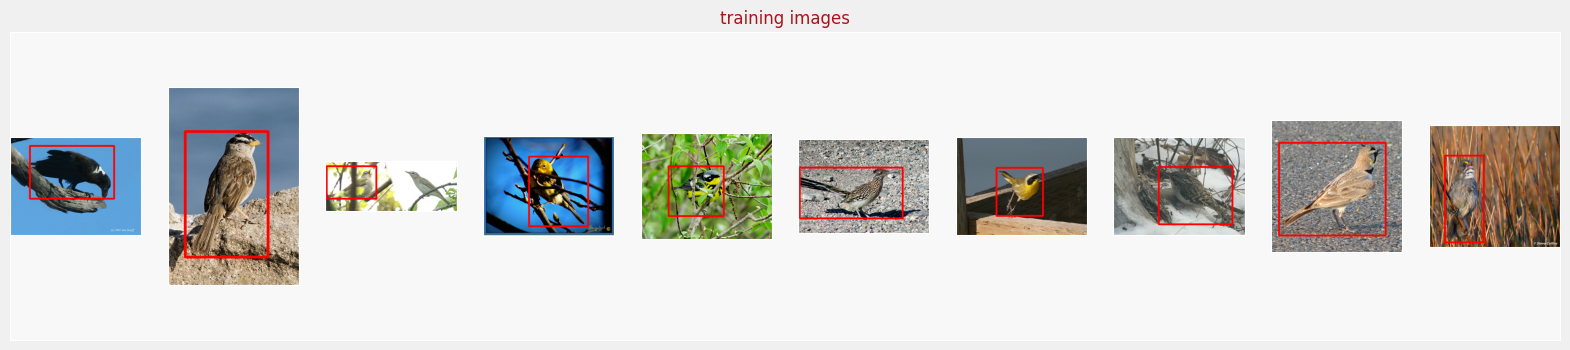

In [14]:
(visualization_training_images, visualization_training_bboxes) = dataset_to_numpy_util(visualization_training_dataset, N=10)
display_digits_with_boxes(np.array(visualization_training_images), np.array([]), np.array(visualization_training_bboxes), np.array([]), "training images")

<ipython-input-8-79882cc51e28>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return (np.array(ds_images), np.array(ds_bboxes))


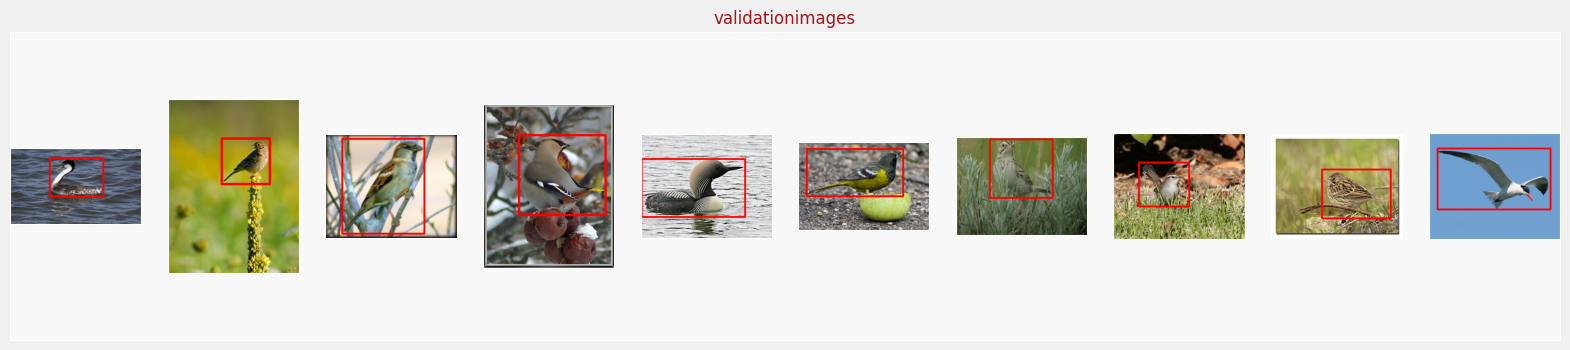

In [15]:
def get_visualization_validation_dataset():
    dataset = tfds.load("caltech_birds2010", split="test", try_gcs=True, data_dir=data_dir)
    visualization_validation_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)
    return visualization_validation_dataset


visualization_validation_dataset = get_visualization_validation_dataset()

(visualization_validation_images, visualization_validation_bboxes) = dataset_to_numpy_util(visualization_validation_dataset, N=10)
display_digits_with_boxes(np.array(visualization_validation_images), np.array([]), np.array(visualization_validation_bboxes), np.array([]), "validationimages")

<li>Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos of 200 bird species (mostly North American). The total number of categories of birds is 200 and there are 6033 images in the 2010 dataset and 11,788 images in the 2011 dataset. Annotations include bounding boxes, segmentation labels.



# Load and prepare the datasets for the model

In [17]:
BATCH_SIZE = 64

# The argument -1 specifies that the pipeline should prefetch an unlimited number of batches, effectively buffering the entire dataset

def get_training_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(-1) 
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    return dataset

training_dataset = get_training_dataset(visualization_training_dataset)
validation_dataset = get_validation_dataset(visualization_validation_dataset) 

# Model Building

In [19]:
# Mobile net
def feature_extractor(inputs):
    ### YOUR CODE HERE ###
    
    # Create a mobilenet version 2 model object
    mobilenet_model = tf.keras.applications.MobileNetV2(input_shape= [224,224,3], include_top=False, weights= 'imagenet')
    

    # pass the inputs into this modle object to get a feature extractor for these inputs
    feature_extractor = mobilenet_model(inputs)
    

    ### END CODE HERE ###
        
    # return the feature_extractor
    return feature_extractor

In [20]:
# Dense Layers
def dense_layers(features):
    ### YOUR CODE HERE ###

    # global average pooling 2D layer.
    x = tf.keras.layers.GlobalAveragePooling2D()(features) 
    
    # flatten layer
    x = tf.keras.layers.Flatten()(x) 
    
    # 1024 Dense layer, with relu
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    
    # 512 Dense layer, with relu
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    
    ### END CODE HERE ###
    
    return x

In [21]:
# output layer
def bounding_box_regression(x):
    ### YOUR CODE HERE ###
    
    # Dense layer named `bounding_box`
    bounding_box_regression_output = tf.keras.layers.Dense(4, name = 'bounding_box')(x) 
    ### END CODE HERE ###
        

    return bounding_box_regression_output

In [22]:
# final model
def final_model(inputs):
    ### YOUR CODE HERE ###

    # features
    feature_cnn = feature_extractor(inputs) 

    # dense layers
    last_dense_layer = dense_layers(feature_cnn) 

    # bounding box
    bounding_box_output = bounding_box_regression(last_dense_layer)
    
    # define the TensorFlow Keras model using the inputs and outputs to your model
    model = tf.keras.models.Model(inputs = inputs, outputs = bounding_box_output)

    ### END CODE HERE ###
    
    
    return model

In [23]:
# defining input layer and compiling model
def define_and_compile_model():
  
    ### YOUR CODE HERE ###

    # define the input layer
    inputs = tf.keras.layers.Input(shape = (224, 224,3))
    
    # create the model
    model = final_model(inputs) 
    
    # compile your model 
    model.compile(optimizer= tf.keras.optimizers.SGD(momentum=0.9) , loss = 'mse' )    
  
    ### END CODE HERE ###
    

    return model

In [24]:
# define your model
model = define_and_compile_model()
# print model layers
model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                

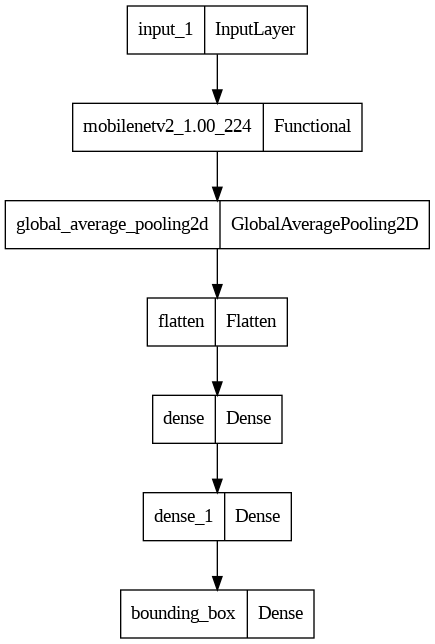

In [25]:
tf.keras.utils.plot_model(model) 

In [26]:
# You'll train 50 epochs
EPOCHS = 50

### START CODE HERE ###


# Choose a batch size
BATCH_SIZE = 64

# Get the length of the training set
length_of_training_dataset = len(visualization_training_dataset) 
print(length_of_training_dataset)

# Get the length of the validation set
length_of_validation_dataset = len(visualization_validation_dataset) 
print(length_of_validation_dataset)

# Get the steps per epoch (may be a few lines of code)
steps_per_epoch = length_of_training_dataset // BATCH_SIZE 
if length_of_training_dataset % BATCH_SIZE > 0:
    steps_per_epoch += 1 

print(steps_per_epoch)

# get the validation steps (per epoch) (may be a few lines of code)
validation_steps = length_of_validation_dataset//BATCH_SIZE
if length_of_validation_dataset % BATCH_SIZE > 0:
    validation_steps += 1
    
print(validation_steps)
### END CODE HERE

3000
3033
47
48


In [27]:
# Fit the model, setting the parameters noted in the instructions above.
history = model.fit(training_dataset , steps_per_epoch= steps_per_epoch, validation_data=validation_dataset, validation_steps = validation_steps, epochs = EPOCHS)


Epoch 1/50
47/47 [==============================] - 66s 822ms/step - loss: 0.0930 - val_loss: 0.3252
Epoch 2/50
47/47 [==============================] - 30s 648ms/step - loss: 0.0184 - val_loss: 0.2363
Epoch 3/50
47/47 [==============================] - 34s 741ms/step - loss: 0.0125 - val_loss: 0.1829
Epoch 4/50
47/47 [==============================] - 36s 771ms/step - loss: 0.0098 - val_loss: 0.1592
Epoch 5/50
47/47 [==============================] - 33s 706ms/step - loss: 0.0081 - val_loss: 0.1386
Epoch 6/50
47/47 [==============================] - 35s 760ms/step - loss: 0.0071 - val_loss: 0.1196
Epoch 7/50
47/47 [==============================] - 33s 706ms/step - loss: 0.0062 - val_loss: 0.0983
Epoch 8/50
47/47 [==============================] - 33s 708ms/step - loss: 0.0054 - val_loss: 0.0869
Epoch 9/50
47/47 [==============================] - 27s 582ms/step - loss: 0.0050 - val_loss: 0.0824
Epoch 10/50
47/47 [==============================] - 33s 703ms/step - loss: 0.0046 - val_lo

# Validate Loss


In [28]:
loss = model.evaluate(validation_dataset, steps=validation_steps)
print("Loss: ", loss)

48/48 [==============================] - 11s 224ms/step - loss: 0.0180
Loss:  0.0179984699934721


# Save Model

In [29]:
# Please save your model
model.save("birds.h5")

# Plot Metrics

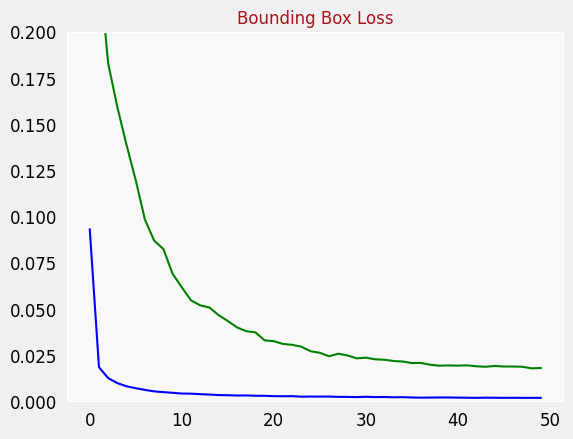

In [30]:
plot_metrics("loss", "Bounding Box Loss", ylim=0.2)

# IOU

In [31]:
def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(xmin_pred, xmin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred + 1) * (ymax_pred - ymin_pred + 1)
    true_box_area = (xmax_true - xmin_true + 1) * (ymax_true - ymin_true + 1)

    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap) + 1,0)  * np.maximum((ymax_overlap - ymin_overlap) + 1, 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    #Updates iou score
    iou = overlap_area / union_area

    return iou

In [32]:
#Makes predictions
original_images, normalized_images, normalized_bboxes = dataset_to_numpy_with_original_bboxes_util(visualization_validation_dataset, N=500)
predicted_bboxes = model.predict(normalized_images, batch_size=32)


#Calculates IOU and reports true positives and false positives based on IOU threshold
iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = 0.7

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

<ipython-input-9-96ace04d9d8e>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(ds_original_images), np.array(ds_images), np.array(ds_bboxes)


16/16 [==============================] - 3s 86ms/step
Number of predictions where iou > threshold(0.7): 319
Number of predictions where iou < threshold(0.7): 181


# Visualize Predictions

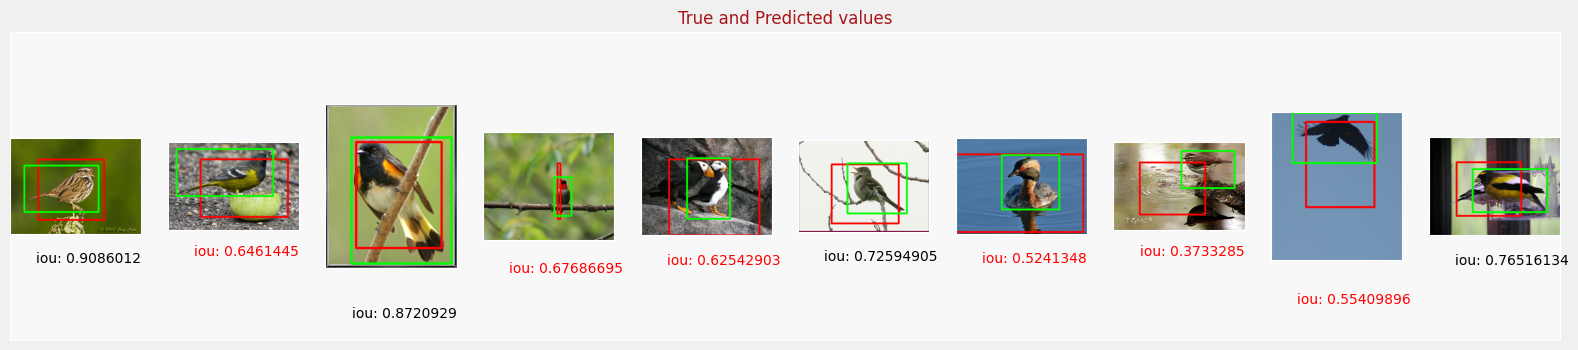

In [33]:
n = 10
indexes = np.random.choice(len(predicted_bboxes), size=n)

iou_to_draw = iou[indexes]
norm_to_draw = original_images[indexes]
display_digits_with_boxes(original_images[indexes], predicted_bboxes[indexes], normalized_bboxes[indexes], iou[indexes], "True and Predicted values", bboxes_normalized=True)
